<a href="https://colab.research.google.com/github/AliAkbarBadri/topics-for-types/blob/main/types_with_topics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
! pip -q install laserembeddings
! python -m laserembeddings download-models
! pip -q install transformers
! pip -q install parsivar

     |████████████████████████████████| 860kB 10.1MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 

✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fcodes    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/93langs.fvocab    
✅   Downloaded https://dl.fbaipublicfiles.com/laser/models/bilstm.93langs.2018-12-26.pt    

✨ You're all set!
     |████████████████████████████████| 1.3MB 10.6MB/s 
     |████████████████████████████████| 1.1MB 48.1MB/s 
     |████████████████████████████████| 2.9MB 54.3MB/s 
     |████████████████████████████████| 36.2MB 75kB/s 
     |████████████████████████████████| 1.5MB 53.3MB/s 


In [2]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoTokenizer, AutoModel
from laserembeddings import Laser
from parsivar import *
from __future__ import unicode_literals

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read Topics

In [19]:
df_topics = pd.read_csv("/content/drive/My Drive/topics-for-types/df_topics.csv")
df_topics.head()

,sentence,اقتصاد,بازی,برنامه‌نویسی,تحصیل,تغذیه,حقوق/قانون,حیوانات,خرید,روابط,روانشناسی,زبان,زیبایی,سرگرمی,سفر,سلامت,فنی,ماشین,مذهبی,ورزش,کار,کامپیوتر/موبایل,کودکان,گیاهان
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


In [20]:
df_topics_np = df_topics[df_topics.columns[1:]].to_numpy()
df_topics_np

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# LASER

In [10]:
laser = Laser()

In [65]:
df_types_laser = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_laser['id'] = df_types_laser.index
df_types_laser

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد,id
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0,1
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0,2
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0,3
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419,تاثیر قرص های لاغری چگونه است؟,0,0,0,0,0,1,0,0,0,0,0,0,2419
2420,عوارض قرص های لاغری در زمان بارداری چیست؟,0,0,0,0,0,1,0,0,1,0,0,0,2420
2421,برای آموزش سه تار چه متد هایی وجود دارد؟,0,0,0,0,0,0,0,0,1,0,0,0,2421
2422,آیا نواختن سه تار سخت است؟,0,1,0,0,0,0,0,0,0,0,0,0,2422


In [67]:
df_types_laser['sentence'] = df_types_laser.apply(lambda row: np.concatenate((np.array(laser.embed_sentences(row.sentence, lang='fa')[0]), df_topics_np[row.id])), axis=1)
df_types_laser = df_types_laser[df_types_laser.columns[:-1]]
df_types_laser.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[0.02094222791492939, -8.114153752103448e-05, ...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[0.00867996271699667, 0.0027223487850278616, -...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.011158587411046028, 0.018385719507932663, -...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.009575149975717068, 0.013646436855196953, 7...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[0.027029111981391907, 0.002408454194664955, 0...",0,0,0,0,1,0,0,0,1,1,0,0


In [70]:
X = np.array(df_types_laser[df_types_laser.columns[0]])
X = np.vstack(X)

Y = df_types_laser[df_types_laser.columns[1:]].values
n_class = Y.shape[1]
X.shape, Y.shape

((2424, 1047), (2424, 12))

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [72]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [82]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer'),
    tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2'),
    tf.keras.layers.Dense(n_class, activation='sigmoid', name='Output'),
  ], name='LASER_Model')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(n_class,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(n_class,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(n_class,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "LASER_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 100)               104800    
_________________________________________________________________
Dense_Layer2 (Dense)         (None, 100)               10100     
_________________________________________________________________
Output (Dense)               (None, 12)                1212      
Total params: 116,112
Trainable params: 116,112
Non-trainable params: 0
_________________________________________________________________
None


In [83]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
218/218 [==============================] - 1s 6ms/step - loss: 0.3197 - acc: 0.4713 - f1: 0.4422 - macro: 0.1311 - micro: 0.5503 - hamloss: 0.1218 - val_loss: 0.2514 - val_acc: 0.4805 - val_f1: 0.5414 - val_macro: 0.1650 - val_micro: 0.6376 - val_hamloss: 0.1014
Epoch 2/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2379 - acc: 0.5384 - f1: 0.5956 - macro: 0.2065 - micro: 0.6751 - hamloss: 0.0956 - val_loss: 0.2178 - val_acc: 0.5606 - val_f1: 0.6231 - val_macro: 0.2303 - val_micro: 0.6987 - val_hamloss: 0.0871
Epoch 3/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2075 - acc: 0.6674 - f1: 0.6555 - macro: 0.2540 - micro: 0.7214 - hamloss: 0.0824 - val_loss: 0.2088 - val_acc: 0.6522 - val_f1: 0.6693 - val_macro: 0.2716 - val_micro: 0.7265 - val_hamloss: 0.0837
Epoch 4/20
218/218 [==============================] - 1s 5ms/step - loss: 0.1913 - acc: 0.7013 - f1: 0.6855 - macro: 0.2855 - micro: 0.7425 - hamloss: 0.0766 - val_loss: 0.1924 -

In [84]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.1874 - acc: 0.6667 - f1: 0.7754 - macro: 0.4297 - micro: 0.7817 - hamloss: 0.0672


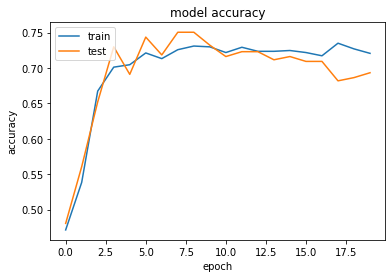

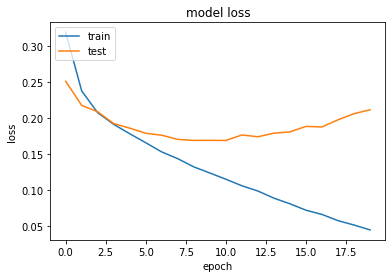

In [85]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# ALBERT

In [86]:
# config = AutoConfig.from_pretrained("m3hrdadfi/albert-fa-base-v2")
# tokenizer = AutoTokenizer.from_pretrained("m3hrdadfi/albert-fa-base-v2")
# bert_model = AutoModel.from_pretrained("m3hrdadfi/albert-fa-base-v2")

In [ ]:
# def get_embedding(sent):
#     input_sentence = torch.tensor(tokenizer.encode(sent, max_length = 500)).unsqueeze(0)
#     out = bert_model(input_sentence)
#     embeddings_of_last_layer = out[0]
#     cls_embeddings = embeddings_of_last_layer[0][0]
#     cls_embeddings = cls_embeddings.detach().numpy()
#     return cls_embeddings

In [ ]:
# df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")

In [ ]:
# df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda sent: get_embedding(sent))
# df_types_bert.to_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv", index=False)
# df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.5841074, -0.017078003, -0.32405344, -0.645...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.31120673, -0.0050979797, 0.10509731, -0.36...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.05544515, -0.23301096, 0.12021764, -0.33959...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.37881416, -0.1909234, 0.16427912, -0.383240...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.46968994, -0.2401005, 0.20189604, -0.20498...",0,0,0,0,1,0,0,0,1,1,0,0


In [89]:
df_types_albert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types_albert.csv")
df_types_albert['sentence'] = df_types_albert['sentence'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))
df_types_albert['id'] = df_types_albert.index
df_types_albert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد,id
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0,1
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0,2
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0,3
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0,4


In [91]:
df_types_albert['sentence'] = df_types_albert.apply(lambda row: np.concatenate((row.sentence, df_topics_np[row.id])), axis=1)
df_types_albert = df_types_albert[df_types_albert.columns[:-1]]
df_types_albert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0


In [92]:
len(df_types_albert.loc[0].sentence)

791

In [93]:
X = np.array(df_types_albert[df_types_albert.columns[0]])
X = np.vstack(X)

Y = df_types_albert[df_types_albert.columns[1:]].values

X.shape, Y.shape

((2424, 791), (2424, 12))

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [95]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [108]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout"),
    # tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2',
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(n_class, activation='sigmoid', name='Dense_Layer3'),

  ], name='ALBERT_MODEL')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(n_class,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(n_class,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(n_class,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "ALBERT_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 32)                25344     
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                396       
Total params: 25,740
Trainable params: 25,740
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
218/218 [==============================] - 1s 5ms/step - loss: 0.2655 - acc: 0.4880 - f1: 0.5465 - macro: 0.1714 - micro: 0.6282 - hamloss: 0.1062 - val_loss: 0.2310 - val_acc: 0.6293 - val_f1: 0.6227 - val_macro: 0.2037 - val_micro: 0.7171 - val_hamloss: 0.0849
Epoch 2/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2159 - acc: 0.6095 - f1: 0.6358 - macro: 0.2455 - micro: 0.7035 - hamloss: 0.0863 - val_loss: 0.2099 - val_acc: 0.6522 - val_f1: 0.6783 - val_macro: 0.2873 - val_micro: 0.7340 - val_hamloss: 0.0799
Epoch 3/20
218/218 [==============================] - 1s 4ms/step - loss: 0.1971 - acc: 0.6439 - f1: 0.6791 - macro: 0.2951 - micro: 0.7291 - hamloss: 0.0798 - val_loss: 0.1976 - val_acc: 0.6773 - val_f1: 0.6849 - val_macro: 0.2956 - val_micro: 0.7366 - val_hamloss: 0.0767
Epoch 4/20
218/218 [==============================] - 1s 4ms/step - loss: 0.1855 - acc: 0.6651 - f1: 0.7075 - macro: 0.3325 - micro: 0.7492 - hamloss: 0.0746 - val_loss: 0.1949 -

In [110]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.2068 - acc: 0.6914 - f1: 0.7109 - macro: 0.4773 - micro: 0.7335 - hamloss: 0.0802


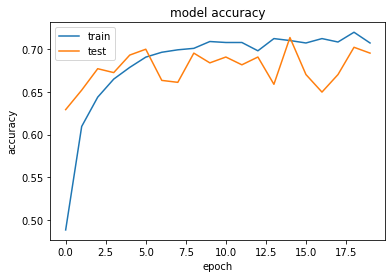

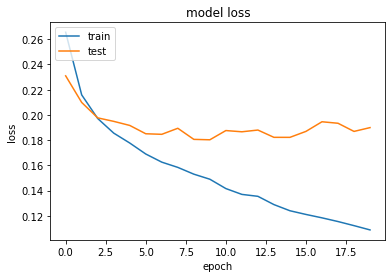

In [111]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# BERT

In [ ]:
# bert_tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")  
# bert_model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

In [ ]:
# def get_embedding(sent):
#     input_sentence = torch.tensor(bert_tokenizer.encode(sent, max_length = 500)).unsqueeze(0)
#     out = bert_model(input_sentence)
#     embeddings_of_last_layer = out[0]
#     cls_embeddings = embeddings_of_last_layer[0][0]
#     cls_embeddings = cls_embeddings.detach().numpy()
#     return cls_embeddings

In [ ]:
# df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")

In [ ]:
# df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda sent: get_embedding(sent))
# df_types_bert.to_csv("/content/drive/My Drive/topics-for-types/df_types_bert.csv", index=False)
# df_types_bert.head()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.9806155, -0.25270098, -0.73519176, 0.52485...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-1.2237562, -1.0405048, -0.82329005, -0.51480...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[-0.17114322, -0.8240524, -0.23230526, -0.3026...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[-0.033276368, -0.39518848, -0.75779915, -0.28...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-1.226232, -0.88978004, -1.1824298, -0.173771...",0,0,0,0,1,0,0,0,1,1,0,0


In [112]:
df_types_bert = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types_albert.csv")
df_types_bert['sentence'] = df_types_bert['sentence'].apply(lambda x: 
                           np.fromstring(
                               x.replace('\n','')
                                .replace('[','')
                                .replace(']','')
                                .replace('  ',' '), sep=' '))
df_types_bert['id'] = df_types_bert.index
df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد,id
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0,1
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0,2
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0,3
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0,4


In [113]:
df_types_bert['sentence'] = df_types_bert.apply(lambda row: np.concatenate((row.sentence, df_topics_np[row.id])), axis=1)
df_types_bert = df_types_bert[df_types_bert.columns[:-1]]
df_types_bert.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[-0.584107399, -0.0170780029, -0.324053437, -0...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.311206728, -0.00509797968, 0.105097309, -0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[0.0554451495, -0.233010963, 0.120217644, -0.3...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.378814161, -0.190923393, 0.164279118, -0.38...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[-0.469689935, -0.240100503, 0.201896042, -0.2...",0,0,0,0,1,0,0,0,1,1,0,0


In [114]:
len(df_types_bert.loc[0].sentence)

791

In [115]:
X = np.array(df_types_bert[df_types_bert.columns[0]])
X = np.vstack(X)

Y = df_types_bert[df_types_bert.columns[1:]].values

X.shape, Y.shape

((2424, 791), (2424, 12))

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [117]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [118]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    tf.keras.layers.Dense(128, activation='relu', name='Dense_Layer',
                          activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout"),
    # tf.keras.layers.Dense(100, activation='relu', name='Dense_Layer2',
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(12, activation='sigmoid', name='Dense_Layer3'),

  ], name='BERT_MODEL')

model.compile(loss='binary_crossentropy', optimizer='rmsprop', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(12,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(12,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(12,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "BERT_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 128)               101376    
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                1548      
Total params: 102,924
Trainable params: 102,924
Non-trainable params: 0
_________________________________________________________________
None


In [119]:
history = model.fit(X_train, y_train, batch_size=8, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
218/218 [==============================] - 1s 6ms/step - loss: 0.4263 - acc: 0.5092 - f1: 0.4806 - macro: 0.1415 - micro: 0.5849 - hamloss: 0.1093 - val_loss: 0.3472 - val_acc: 0.5584 - val_f1: 0.5097 - val_macro: 0.1518 - val_micro: 0.6151 - val_hamloss: 0.1014
Epoch 2/15
218/218 [==============================] - 1s 4ms/step - loss: 0.3169 - acc: 0.6290 - f1: 0.5936 - macro: 0.1893 - micro: 0.6842 - hamloss: 0.0889 - val_loss: 0.3012 - val_acc: 0.6659 - val_f1: 0.6097 - val_macro: 0.1981 - val_micro: 0.6989 - val_hamloss: 0.0854
Epoch 3/15
218/218 [==============================] - 1s 4ms/step - loss: 0.2800 - acc: 0.6709 - f1: 0.6150 - macro: 0.2027 - micro: 0.7014 - hamloss: 0.0846 - val_loss: 0.2856 - val_acc: 0.6705 - val_f1: 0.6272 - val_macro: 0.2204 - val_micro: 0.7059 - val_hamloss: 0.0849
Epoch 4/15
218/218 [==============================] - 1s 5ms/step - loss: 0.2567 - acc: 0.6875 - f1: 0.6439 - macro: 0.2331 - micro: 0.7212 - hamloss: 0.0796 - val_loss: 0.2629 -

In [120]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 3ms/step - loss: 0.2245 - acc: 0.7325 - f1: 0.7073 - macro: 0.3488 - micro: 0.7355 - hamloss: 0.0782


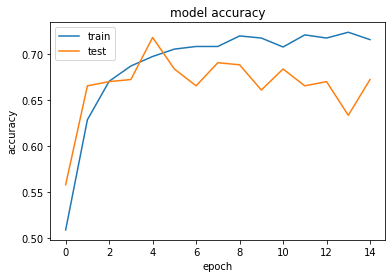

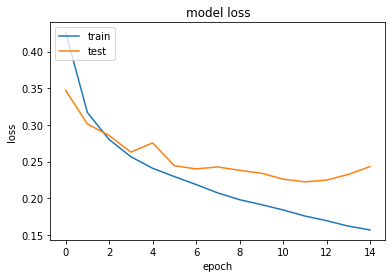

In [121]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Word2Vec

In [122]:
embeddings_dictionary = dict()

w2v_file = open('drive/My Drive/nlp/similarity/embeddings/twitt_wiki_ham_blog.fa.text.100.vec', encoding="utf8")

for line in w2v_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
w2v_file.close()

In [126]:
df_types_w2v = pd.read_csv("/content/drive/My Drive/topics-for-types/df_types.csv")
df_types_w2v['id'] = df_types_w2v.index
df_types_w2v.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد,id
0,تفاوت ترمز عقب دیسکی و کاسه ای چیست؟,0,0,0,0,1,1,0,0,0,1,0,0,0
1,آیا ترمز ضدقفل ABS در همه چرخ ها عمل می کند؟,0,1,0,0,0,1,0,0,0,1,0,0,1
2,چرا باوجود نصب بودن ترمز ABS بر روی خودرو، ترم...,0,0,0,0,0,1,1,0,0,1,0,0,2
3,چرا با وجود نصب بودن Airbag بر روی خودرو، در ه...,0,0,0,0,0,1,1,0,0,1,0,0,3
4,کلاس های مختلف خودرو چگونه شناسایی می شوند؟,0,0,0,0,1,0,0,0,1,1,0,0,4


In [124]:
parsivar_tokenizer = Tokenizer()
parsivar_normalizer = Normalizer(statistical_space_correction=False)

In [128]:
def get_w2v_embedding(sent):
    sent_tokens = parsivar_tokenizer.tokenize_words(parsivar_normalizer.normalize(sent))
    tokens_embeddings = []
    for token in sent_tokens:
      if token in embeddings_dictionary.keys():
        tokens_embeddings.append(embeddings_dictionary[token])
    sent_embedding = np.mean(tokens_embeddings, axis=0)
    return sent_embedding

In [129]:
len(get_w2v_embedding(df_types_w2v.loc[0].sentence))

100

In [132]:
df_types_w2v['sentence'] = df_types_w2v.apply(lambda row: np.concatenate((get_w2v_embedding(row.sentence),df_topics_np[row.id])), axis=1)
df_types_w2v = df_types_w2v[df_types_w2v.columns[:-1]]
df_types_w2v.head()

,sentence,انتخاب,بله/خیر,ترجمه,تعامل,تعریف,توضیح,دلیل,ریاضی,لیست,نظر,واقعیت,پیشنهاد
0,"[0.15668366849422455, -0.283892422914505, 0.90...",0,0,0,0,1,1,0,0,0,1,0,0
1,"[-0.12556250393390656, -1.6543718576431274, -0...",0,1,0,0,0,1,0,0,0,1,0,0
2,"[-0.06706424802541733, -1.07315993309021, 1.26...",0,0,0,0,0,1,1,0,0,1,0,0
3,"[0.3817482888698578, -1.376911997795105, 0.927...",0,0,0,0,0,1,1,0,0,1,0,0
4,"[0.9607437252998352, -0.7673529982566833, -2.3...",0,0,0,0,1,0,0,0,1,1,0,0


In [133]:
len(df_types_w2v.loc[0].sentence)

123

In [134]:
X = np.array(df_types_w2v[df_types_w2v.columns[0]])
X = np.vstack(X)

Y = df_types_w2v[df_types_w2v.columns[1:]].values
n_class = Y.shape[1]

X.shape, Y.shape

((2424, 123), (2424, 12))

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [136]:
len(X_train),len(X_test),len(y_train),len(y_test)

(2181, 243, 2181, 243)

In [137]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X[0].shape, name='input_layer'),
    # tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer0'),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout0"),
    tf.keras.layers.Dense(16, activation='relu', name='Dense_Layer1'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout1"),
    # tf.keras.layers.Dense(32, activation='relu', name='Dense_Layer2'),
                          # activity_regularizer=tf.keras.regularizers.l2()),
    # tf.keras.layers.Dropout(rate=0.2, name="Dropout2"),
    tf.keras.layers.Dense(n_class, activation='sigmoid', name='Dense_Layer3'),

  ], name='Word2Vec_MODEL')

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['acc',
                       tfa.metrics.f_scores.F1Score(n_class,'weighted', threshold=0.5, name='f1'),
                       tfa.metrics.f_scores.F1Score(n_class,'macro',threshold=0.5, name='macro'),
                       tfa.metrics.f_scores.F1Score(n_class,'micro',threshold=0.5, name='micro'),
                       tfa.metrics.HammingLoss(mode='multilabel',threshold=0.5, name='hamloss')])
print(model.summary())

Model: "Word2Vec_MODEL"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer1 (Dense)         (None, 16)                1984      
_________________________________________________________________
Dense_Layer3 (Dense)         (None, 12)                204       
Total params: 2,188
Trainable params: 2,188
Non-trainable params: 0
_________________________________________________________________
None


In [138]:
history = model.fit(X_train, y_train, batch_size=8, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
218/218 [==============================] - 1s 5ms/step - loss: 0.3794 - acc: 0.4243 - f1: 0.4562 - macro: 0.1767 - micro: 0.4634 - hamloss: 0.1674 - val_loss: 0.2863 - val_acc: 0.4737 - val_f1: 0.4892 - val_macro: 0.1672 - val_micro: 0.5798 - val_hamloss: 0.1175
Epoch 2/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2598 - acc: 0.4776 - f1: 0.5571 - macro: 0.2152 - micro: 0.6273 - hamloss: 0.1059 - val_loss: 0.2661 - val_acc: 0.4874 - val_f1: 0.5521 - val_macro: 0.2203 - val_micro: 0.6302 - val_hamloss: 0.1083
Epoch 3/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2399 - acc: 0.5120 - f1: 0.6096 - macro: 0.2565 - micro: 0.6680 - hamloss: 0.0978 - val_loss: 0.2553 - val_acc: 0.5995 - val_f1: 0.5760 - val_macro: 0.2317 - val_micro: 0.6501 - val_hamloss: 0.1022
Epoch 4/20
218/218 [==============================] - 1s 4ms/step - loss: 0.2265 - acc: 0.5700 - f1: 0.6427 - macro: 0.2895 - micro: 0.6930 - hamloss: 0.0916 - val_loss: 0.2446 -

In [139]:
score = model.evaluate(X_test, y_test, verbose=1)

8/8 [==============================] - 0s 4ms/step - loss: 0.2155 - acc: 0.5761 - f1: 0.7135 - macro: 0.3384 - micro: 0.7398 - hamloss: 0.0806


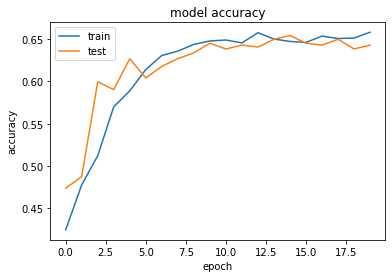

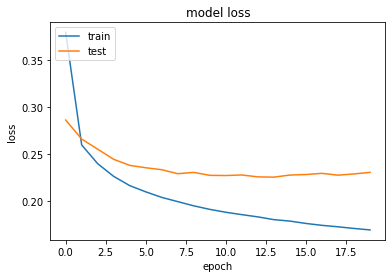

In [140]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()